## For new strategy images

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import sys
sys.path.append("/home/jupyter/DIG-In/src/vit_patching/models")
import patch_utils as pu
np.random.seed(42)
import get_patch_ViT16_features_v1 as gp
from lang_sam import LangSAM
from PIL import Image
import torch
import copy

In [2]:
import imp
imp.reload(pu)

/var/tmp/ipykernel_3738/4090393492.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'patch_utils' from '/home/jupyter/DIG-In/src/vit_patching/models/patch_utils.py'>

In [3]:
import torchvision.transforms.functional as F

In [4]:
model = LangSAM()

/opt/conda/envs/langsam2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jupyter/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [5]:
full_img_root = "/home/jupyter/geode/images"
full_img_gen_root_new = "/home/jupyter/696DS-data/generated" # strategy - 2
full_img_gen_root = "/home/jupyter/696DS-data/generated-data" # strategy-1

In [6]:
objects_file="/home/jupyter/DIG-In/data/seg_low_patches_removed_objects.pkl"
geode_file = "/home/jupyter/DIG-In/data/geode_27_objects.csv"
gen_file = "/home/jupyter/DIG-In/pipeline/data/prompting_2/processed_df_geode_gen.csv"

In [7]:
with open(objects_file, 'rb') as f:
    objects = pickle.load(f)
# objects

In [8]:
considered_objs = ["car", "bag"]


In [9]:
geode_df = pd.read_csv(geode_file)
gen_df = pd.read_csv(gen_file)

In [10]:
img_size = 224
n_patches = 224 // 16
transforms_list = transforms.Compose([
        gp.CenterCropLongEdge(),
        transforms.Resize(img_size),  # Use dynamic img_size based on the model
        transforms.ToTensor(),
        # TRANSFORM_NORMALIZE
    ])
    
preprocessor1 = transforms_list
preprocessor2 = gp.TRANSFORM_NORMALIZE

In [11]:
def plot_sampled_images(image_paths, obj, save_fig_name="test.png", save_fig = False, region="", title=""):
    x,y = 2,3
    fig, axs = plt.subplots(x, y, figsize=(6, 4))
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    for i in range(x*y):

        image_pil = Image.open(image_paths[i])
        masks, boxes, phrases, logits = model.predict(image_pil, obj)

        merged_tensor = torch.any(masks, dim=0, keepdim=True)
        numpy_mask = merged_tensor.squeeze().numpy()
        img, patch_mask = gp.relevant_image_and_patch_mask(image_pil, numpy_mask, 224 //16, preprocessor1, do_obj_seg=False, use_compliment_for_BG=True, use_blackened=False)

        img3 = pu.border_and_alpha(img, patch_mask, fill_alpha=False)
        idx=i
        axs[idx // y,idx%y].imshow(img3)
        axs[idx // y,idx%y].set_xticks([], [])
        axs[idx // y,idx%y].set_yticks([], [])
        
        
        axs[idx // y,idx%y].spines['top'].set_visible(False)
        axs[idx // y,idx%y].spines['right'].set_visible(False)
        axs[idx // y,idx%y].spines['bottom'].set_visible(False)
        axs[idx // y,idx%y].spines['left'].set_visible(False)
    if region!="":
        axs[1, 0].set_ylabel(f'{region}', fontsize=30, labelpad=10)
        axs[1, 0].yaxis.set_label_coords(-0.15, 1)
    if title!="":
        title_obj = axs[0, 1].set_title(f"{title}", fontsize=30, pad=20)
        title_obj.set_position([1.00, 1.03])
    if save_fig:
        plt.savefig(save_fig_name,bbox_inches='tight', dpi=400)
    plt.show()


In [11]:
# Images_objects = {
#     "real":[],
#     "fake": []
# }

In [13]:
import json

In [14]:
# seg_file = "./bg_only_sampled_images_new_strategy.json"
seg_file = "./obj_only_sampled_images.json"
with open(seg_file, 'r') as f:
    data = json.load(f)

In [ ]:
# data["real"]

In [15]:
s = "/work/pi_dhruveshpate_umass_edu/project_21/data/geode/images"
t = full_img_root
data["real"] = [[x.replace(s,t) for x in y] for y in data['real']]

In [16]:
s= "/work/pi_dhruveshpate_umass_edu/project_21/data/generated-data"
t = full_img_gen_root
data["fake"] = [[x.replace(s,t) for x in y] for y in data['fake']]

In [17]:
# np.random.seed(42)

bag
['Europe', 'Africa', 'WestAsia']


/opt/conda/envs/langsam2/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/envs/langsam2/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


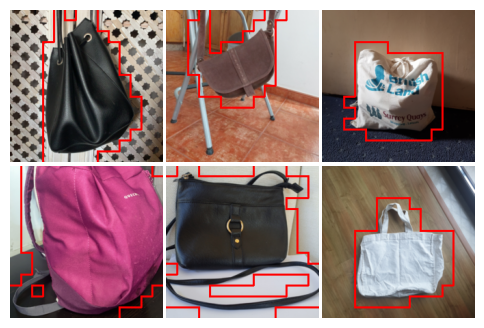

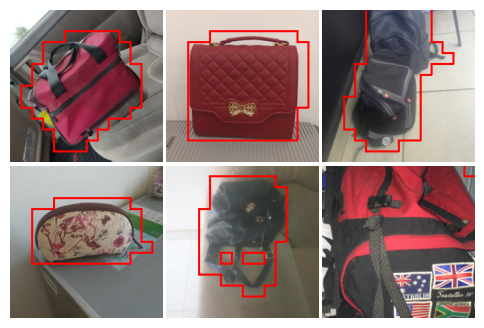

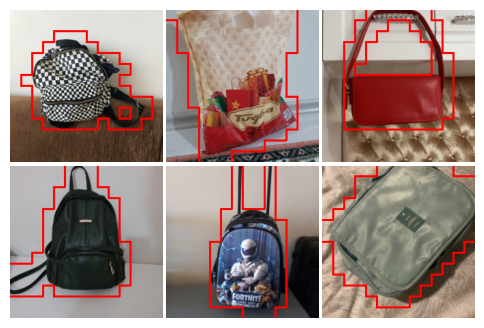

car
['Europe', 'Africa', 'WestAsia']


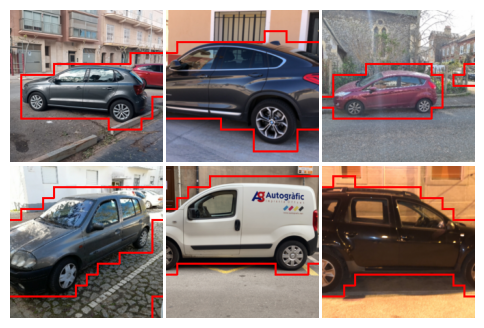

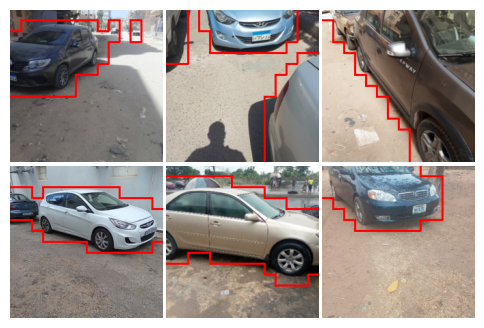

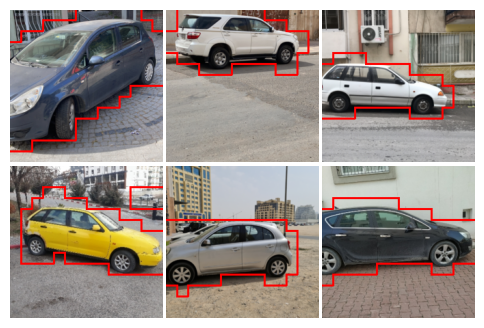

In [18]:
considered_regions = ['Europe', 
                      'Africa', 'WestAsia'
                     #  'SouthEastAsia',
                    #    'Americas', 'EastAsia'
                       ]
considered_objs = ["bag", 
                   "car"
                  ]

df = geode_df
i = 0
for obj in considered_objs:
    print(obj)
    print(considered_regions)
    for region in considered_regions:
        # temp = df[(df["object"]==obj)*(df["region"]==region)]
        # file_paths = np.array(temp["file_path"].values)
        # sampled = np.random.choice(file_paths, replace=False, size=(9))
        # sampled = list(sampled)
        # sampled = [f"{full_img_root}/{samp}" for samp in sampled]
        sampled=data['real'][i]
        i += 1
        # Images_objects["real"].append(sampled)
        # print(f"{obj} - {region}")
        # if obj=="Car":
        #     r = region
        # else:
        #     r = ""
        # if region=="Europe":
        #     title = "GeoDE"
        # else:
        #     title=""
        title=""
        r=""
        plot_sampled_images(sampled, obj, save_fig=True, save_fig_name=f"./geode/{obj}-{region}.png", region=r, title=title)
        
        

In [19]:
np.random.seed(42)

bag
['Africa', 'Europe', 'West Asia']


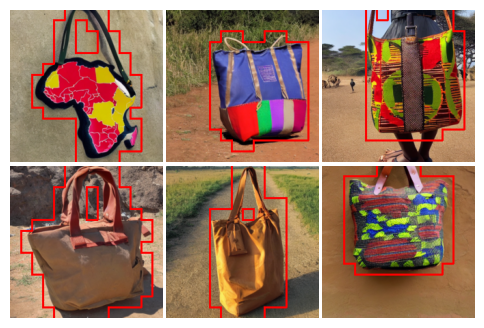

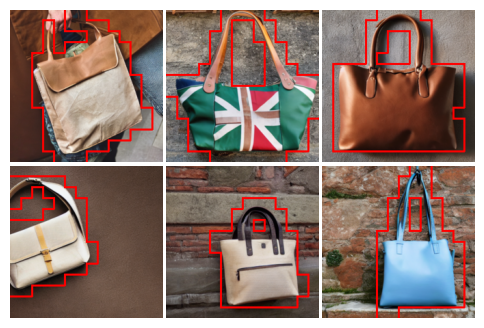

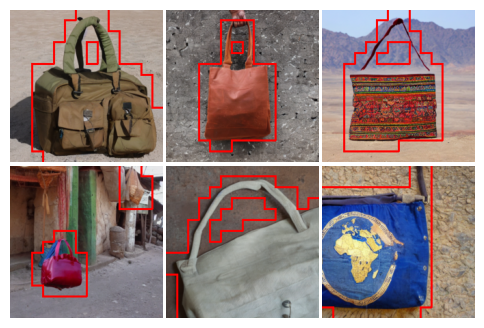

car
['Africa', 'Europe', 'West Asia']


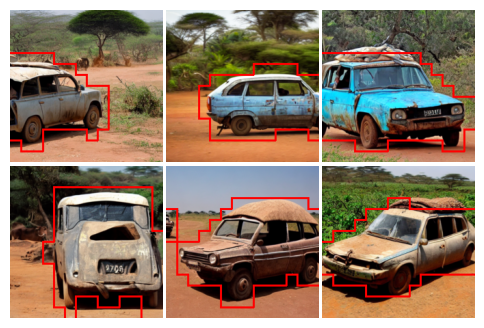

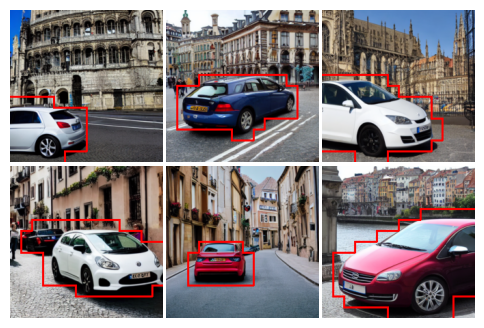

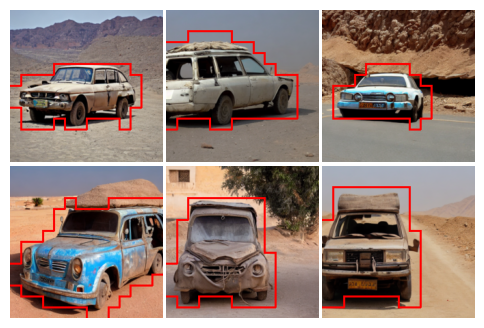

In [20]:
considered_regions = ["Africa", "Europe", 'West Asia']
df = gen_df
i=0
for obj in considered_objs:
    print(obj)
    print(considered_regions)
    for region in considered_regions:
        # temp = df[(df["object"]==obj)*(df["region"]==region)]
        # file_paths = np.array(temp["file_path"].values)
        # sampled = np.random.choice(file_paths, replace=False, size=(9))
        # sampled = list(sampled)
        # sampled = [f"{full_img_gen_root}/{samp}" for samp in sampled]
        # Images_objects["fake"].append(sampled)
        # print(f"{obj} - {region}")
        sampled=data['fake'][i]
        i += 1
        plot_sampled_images(sampled,obj, save_fig=True, save_fig_name=f"./generated/{obj}-{region}.png")

        

In [21]:
import json
with open("./obj_only_sampled_images_new_strategy.json", 'r') as f:
    data_new = json.load(f)

bag
['Africa', 'Europe', 'West Asia']


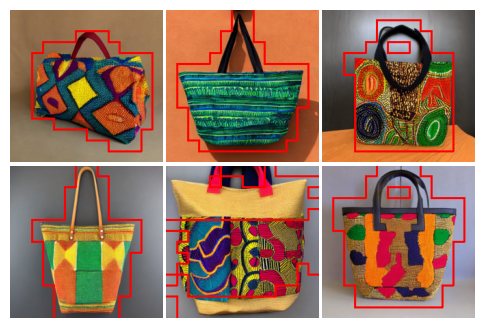

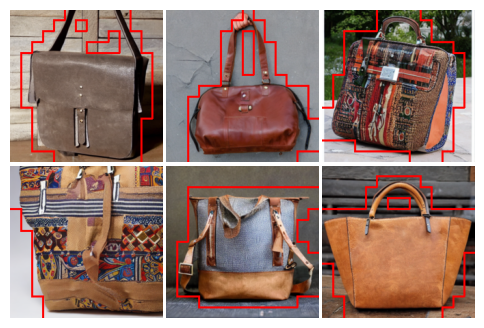

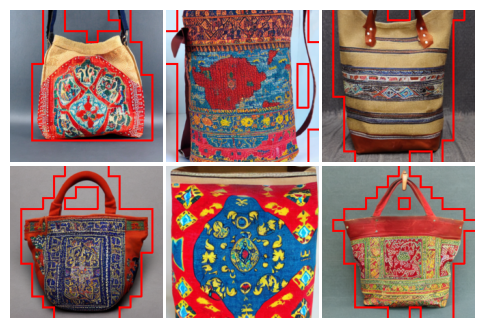

car
['Africa', 'Europe', 'West Asia']


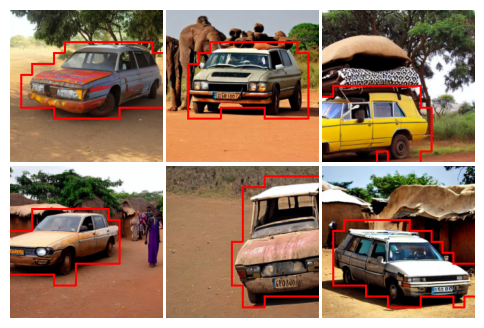

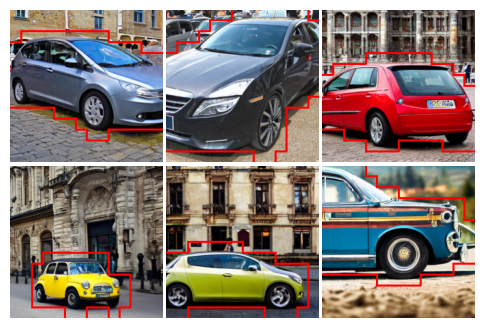

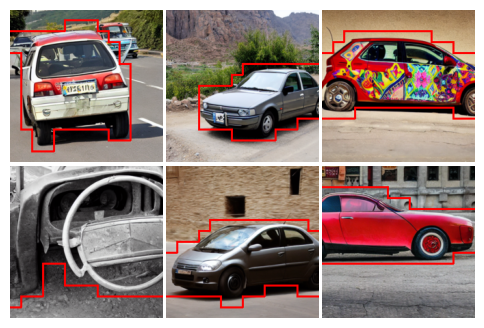

In [22]:
i=0
for obj in considered_objs:
    print(obj)
    print(considered_regions)
    for region in considered_regions:
        # temp = df[(df["object"]==obj)*(df["region"]==region)]
        # file_paths = np.array(temp["file_path"].values)
        # sampled = np.random.choice(file_paths, replace=False, size=(9))
        # sampled = list(sampled)
        # sampled = [f"{full_img_gen_root}/{samp}" for samp in sampled]
        # Images_objects["fake"].append(sampled)
        # print(f"{obj} - {region}")
        sampled=data_new['fake'][i]
        i += 1
        plot_sampled_images(sampled,obj, save_fig=True, save_fig_name=f"./generated-new/{obj}-{region}.png")
